In [1]:
#Importing packages
import pandas as pd
import numpy as np  
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
import matplotlib.pyplot as plt

In [2]:
#Reading in training data
hndl = open("titanic/train.csv")
dftr = pd.read_csv(hndl)
dftr.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


This is a brief view of the training data available to us. From all available fields we have to find out which of these are relevant to the survivability of the passengers on board. We can see that the Name, Ticket and PassengerID all serve the same purpose of identifying the passenger. Therefore, we will eventually drop ticket and PassengerID.

In [3]:
#Overall survival rate
print(dftr['Survived'].value_counts(normalize=True))
#Survival rate as per class
print(dftr['Survived'].groupby(dftr['Pclass']).mean())
#Survival rate as per sex
print(dftr['Survived'].groupby(dftr['Sex']).mean())

Survived
0    0.616162
1    0.383838
Name: proportion, dtype: float64
Pclass
1    0.629630
2    0.472826
3    0.242363
Name: Survived, dtype: float64
Sex
female    0.742038
male      0.188908
Name: Survived, dtype: float64


From above data we an see that <b>sex</b> and <b>ticket class</b> have a significant effect on the survivability of passengers. Thus, these are data fields we should include in our model.

In [4]:
#Splitting into 5 groups and showing their averages
dftr['Survived'].groupby(pd.qcut(dftr['Age'],5)).mean()

Age
(0.419, 19.0]    0.481707
(19.0, 25.0]     0.328467
(25.0, 31.8]     0.393701
(31.8, 41.0]     0.437500
(41.0, 80.0]     0.373239
Name: Survived, dtype: float64

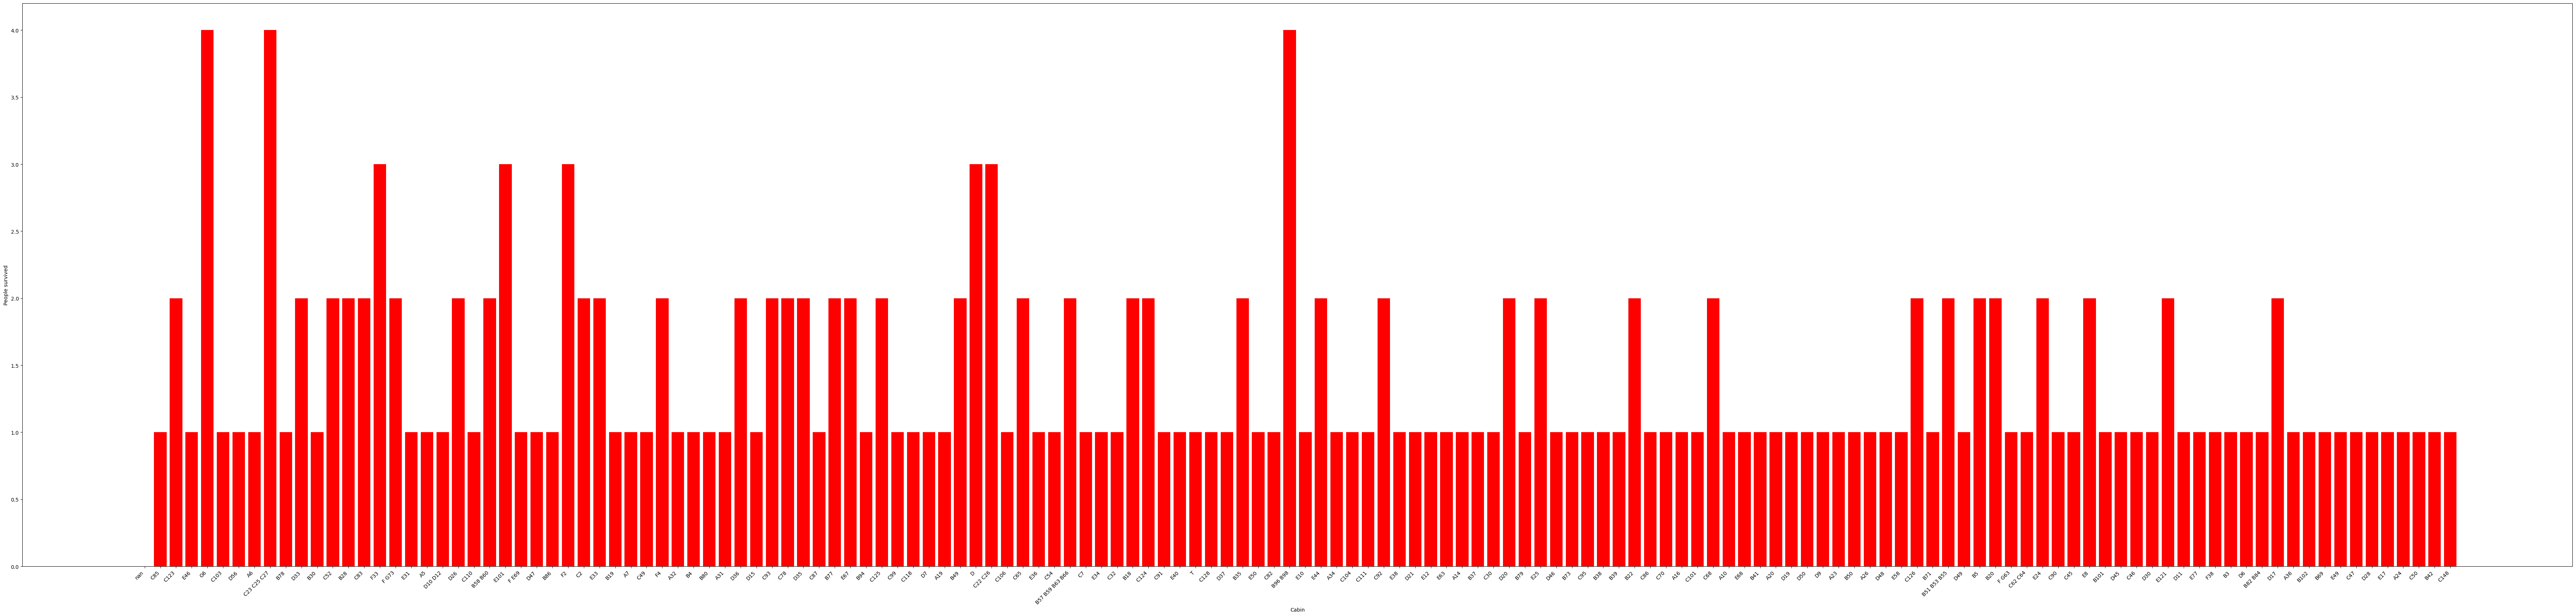

In [5]:
# Getting data of the number of passengers survived in each cabin 
cab = dftr.Cabin.unique().astype(str)
survival_counts = []

for cabin in cab:
    i=dftr.loc[dftr['Cabin']==cabin]
    count=i.shape[0]
    survival_counts.append(count)

# Plotting the Data 
plt.figure(figsize=(90,20))
plt.bar(cab,survival_counts,color='red')
plt.xlabel('Cabin')
plt.ylabel('People survived')
plt.xticks(rotation=45,ha="right")

plt.show()

Here we see that, the cabin number does not have a significant effect on the survivability. Thus, for the sake of our preliminary model we will drop this as well. Additionally, the point of embarkment should not have a measurable effect as well, thus we will drop that too.

In [6]:
#Dropping Name, Embarked, Ticket and storing data in dftrm
dftrm=dftr.drop(['Name','Embarked','Ticket','Cabin', 'Fare'],axis=1)
#Removing rows with NA values
dftrm = dftrm.dropna()
#Display of DF
dftrm.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch
0,1,0,3,male,22.0,1,0
1,2,1,1,female,38.0,1,0
2,3,1,3,female,26.0,0,0
3,4,1,1,female,35.0,1,0
4,5,0,3,male,35.0,0,0


This is our resultant training data upon which we will perform regression.

In [7]:
#Imporatant statistics
dftrm.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
PassengerId,714.0,448.582633,259.119524,1.00,222.250,445.0,677.75,891.0
Survived,714.0,0.406162,0.491460,0.00,0.000,0.0,1.00,1.0
Pclass,714.0,2.236695,0.838250,1.00,1.000,2.0,3.00,3.0
Age,714.0,29.699118,14.526497,0.42,20.125,28.0,38.00,80.0
SibSp,714.0,0.512605,0.929783,0.00,0.000,0.0,1.00,5.0
Parch,714.0,0.431373,0.853289,0.00,0.000,0.0,1.00,6.0


As we can see from above the input fields have a wide variety of ranges. The next step is to perform <b>normalisation</b>. This will be important for the models stability.

In [8]:
#Creating clone for normalisation
dftrm_normal = dftrm.copy()
#Dealing with categorical variables
dftrm_normal['Sex'] = dftrm_normal['Sex'].replace({'male': 1, 'female': 0})
#Using maximum normalisation
for field in dftrm_normal:
    if field in ['Age']:
        dftrm_normal[field] = (dftrm_normal[field]/dftrm_normal[field].abs().max())
    else: 
        continue
#Dropping SibSp and ParCh for simplicity
dftrm_normal = dftrm_normal.drop(['SibSp', 'Parch'], axis = 1)
#View
dftrm_normal.head()

,PassengerId,Survived,Pclass,Sex,Age
0,1,0,3,1,0.2750
1,2,1,1,0,0.4750
2,3,1,3,0,0.3250
3,4,1,1,0,0.4375
4,5,0,3,1,0.4375


This is what we will be taking into out final model.

In [15]:
#Creating the model
#Making input arrays
X_train = dftrm_normal[['Sex', 'Age', 'Pclass']].to_numpy()
Y_train = dftrm_normal[['Survived']].to_numpy()
#Fitting to decision tree
clf = RandomForestClassifier()
clf.fit(X_train,Y_train.ravel())
#Getting predictions
Y_pred = (clf.predict(X_train))